# Political Parties Funding - Exploratory Analysis

This notebooks intends to present an exploratory analysis about the dataset of Brazilian's political parties revenue. This dataset has been made available by Tribunal Superior Eleitoral recently (2018/06) and contains all the revenue streams of the parties in 2017. The dataset was downloaded in 07/2018, so, the state of the data here is the one that was made available by that time. Since I began this work, TSE has added more information to the dataset, some of them suggested by me after identifying problems/improvements for it.

This is a project for the Data Mining class of the Master Degree Program of CEFET/RJ (PPCIC), conducted by professor [Eduardo Ogasawara](http://eic.cefet-rj.br/~eogasawara/data-mining-course-2018-t2/)

The dataset we're going to use can be download in a .rar format and constains a CSV file for each state of the country and one for the country. We're going to work with the country level file, which is the biggest

As the first step, data is going to be loaded from the CSV file and I'm going to begin to explore the data and apply some preprocessing techiniques to get to a state where data mining can be applied.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy import stats
from sklearn.cluster import KMeans

%matplotlib inline

# Loading BRASIL dataset to a pandas DataFrame
# enconding and na_values are specified on the documentation provided within the dataset
receitas_br_df = pd.read_csv('receita_anual_2017_BR.csv',
                             sep=';', encoding='latin-1',
                             na_values=['#NULO#', -1], thousands='.',
                             decimal=',', low_memory=False)

# Set pandas to only show two digits for decimals
# pd.set_option('float_format', '{:.2f}'.format)

# Showing general information about the dataset
receitas_br_df.info()
# Showing the first five rows of the dataset
receitas_br_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 330606 entries, 0 to 330605
Data columns (total 36 columns):
DT_GERACAO                        330606 non-null object
HH_GERACAO                        330606 non-null object
CD_TP_ESFERA_PARTIDARIA           330606 non-null int64
DS_TP_ESPERA_PARTIDARIA           330606 non-null object
SG_UF                             330606 non-null object
CD_MUNICIPIO                      0 non-null float64
NM_MUNICIPIO                      0 non-null float64
NR_ZONA                           0 non-null float64
NR_CNPJ_PRESTADOR_CONTA           330606 non-null int64
SG_PARTIDO                        330606 non-null object
NM_PARTIDO                        330606 non-null object
CD_TP_ORIGEM_DOACAO               329463 non-null float64
DS_TP_ORIGEM_DOACAO               329463 non-null object
NR_CPF_CNPJ_DOADOR                328645 non-null float64
NM_DOADOR                         328645 non-null object
CD_TP_ESFERA_PARTIDARIA_DOADOR    329463 non-n

,DT_GERACAO,HH_GERACAO,CD_TP_ESFERA_PARTIDARIA,DS_TP_ESPERA_PARTIDARIA,SG_UF,CD_MUNICIPIO,NM_MUNICIPIO,NR_ZONA,NR_CNPJ_PRESTADOR_CONTA,SG_PARTIDO,...,DS_TP_FONTE_RECURSO,CD_TP_NATUREZA_RECURSO,DS_TP_NATUREZA_RECURSO,CD_TP_ESPECIE_RECURSO,DS_TP_ESPECIE_RECURSO,NR_RECIBO_DOACAO,NR_DOCUMENTO,DT_RECEITA,DS_RECEITA,VR_RECEITA
0,19/06/2018,16:59:31,0,NACIONAL,BR,NaN,NaN,NaN,59933952000100,AVANTE,...,OUTROS RECURSOS,0,Financeiro,7.0,Transferência eletrônica,NaN,NaN,20/09/2017,RECURSOS DE ORIGEM NÃO IDENTIFICADA,705.48
1,19/06/2018,16:59:31,0,NACIONAL,BR,NaN,NaN,NaN,59933952000100,AVANTE,...,FUNDO PARTIDÁRIO,0,Financeiro,NaN,NaN,NaN,NaN,07/04/2017,JUROS E OUTRAS RENDAS - Descontos obtidos,6.01
2,19/06/2018,16:59:31,0,NACIONAL,BR,NaN,NaN,NaN,59933952000100,AVANTE,...,FUNDO PARTIDÁRIO,0,Financeiro,NaN,NaN,NaN,NaN,14/09/2017,JUROS E OUTRAS RENDAS - Descontos obtidos,10.60
3,19/06/2018,16:59:31,0,NACIONAL,BR,NaN,NaN,NaN,59933952000100,AVANTE,...,FUNDO PARTIDÁRIO,0,Financeiro,NaN,NaN,NaN,NaN,11/10/2017,JUROS E OUTRAS RENDAS - Descontos obtidos,10.00
4,19/06/2018,16:59:31,0,NACIONAL,BR,NaN,NaN,NaN,59933952000100,AVANTE,...,FUNDO PARTIDÁRIO,0,Financeiro,NaN,NaN,NaN,NaN,30/10/2017,JUROS E OUTRAS RENDAS - Descontos obtidos,0.90


We can see on the dataframe info that there are some columns that have 0 values. This means that all their values are null. So, we're going to drop them from the dataframe since they'll have no use for us. We're also going to get rid of some columns that have only a single value (like `SG_UF` that is equal to `BR` for all rows) and others that we think will not be useful for our analysis and algorithms.

In [2]:
# Setting a function to drop single values columns
def columns_single_value(df):
    
    count_dict = {}
    single_value_col = []
    
    for column in df:
        count_dict[column] = df[column].nunique()
        if count_dict[column] == 1:
            single_value_col.append(column)
    return single_value_col


# Dropping the columns that have 0 values (all nulls)
receitas_br_df = receitas_br_df.drop(['CD_MUNICIPIO', 'NM_MUNICIPIO', 'NR_ZONA',
                                      'CD_MUNICIPIO_DOADOR', 'NM_MUNICIPIO_DOADOR',
                                      'NR_ZONA_DOADOR'], axis=1)

# Storing in a variable all the columns of the DataFrame that have a single unique value
single_value_cols = columns_single_value(receitas_br_df)

# Dropping single value columns. Those columns, in the context of this dataset and analysis are not
# going to be valuable, so, it's better to get rid of them to continue the working with a DataFrame
# with less dimensions but meaningful ones
receitas_br_df = receitas_br_df.drop(single_value_cols, axis=1)

# Dropping not useful columns (that will not be used for analysis or data mining techniques)
receitas_br_df.drop(['NR_RECIBO_DOACAO', 'NR_DOCUMENTO'], inplace=True, axis=1)

# Printing the general info of the DataFrame again to see the new state of it
receitas_br_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 330606 entries, 0 to 330605
Data columns (total 20 columns):
NR_CNPJ_PRESTADOR_CONTA      330606 non-null int64
SG_PARTIDO                   330606 non-null object
NM_PARTIDO                   330606 non-null object
CD_TP_ORIGEM_DOACAO          329463 non-null float64
DS_TP_ORIGEM_DOACAO          329463 non-null object
NR_CPF_CNPJ_DOADOR           328645 non-null float64
NM_DOADOR                    328645 non-null object
SQ_CANDIDATO_DOADOR          96 non-null float64
NR_CANDIDATO_DOADOR          96 non-null float64
CD_CANDIDATO_CARGO_DOADOR    96 non-null float64
DS_CANDIDATO_CARGO_DOADOR    96 non-null object
CD_TP_FONTE_RECURSO          330606 non-null int64
DS_TP_FONTE_RECURSO          330606 non-null object
CD_TP_NATUREZA_RECURSO       330606 non-null int64
DS_TP_NATUREZA_RECURSO       330606 non-null object
CD_TP_ESPECIE_RECURSO        330405 non-null float64
DS_TP_ESPECIE_RECURSO        330405 non-null object
DT_RECEITA        

After our initial effort of data cleaning we can still see that there are some columns with missing values since they don't have values for every data sample. These are the fields:

```
CD_TP_ORIGEM_DOACAO          329463 non-null float64
DS_TP_ORIGEM_DOACAO          329463 non-null object
NR_CPF_CNPJ_DOADOR           328645 non-null float64
NM_DOADOR                    328645 non-null object
CD_TP_ESPECIE_RECURSO        330405 non-null float64
DS_TP_ESPECIE_RECURSO        330405 non-null object
```

The columns related to donations from candidates also has a small number of data points (96), but it makes sense because they're just need to be filled for this type of donation.

To decide what to do, let's see how much of the revenue share dos `NaN` class donations represents for our dataset.

In [3]:
doacoes_nan = receitas_br_df[receitas_br_df['CD_TP_ORIGEM_DOACAO'].isnull()]
                                                  
print('Sum of {}: {}. Share of revenue: {}'.format('Doações NaN',
                                                   sum(doacoes_nan['VR_RECEITA']),
                                                   sum(doacoes_nan['VR_RECEITA']) / sum(receitas_br_df['VR_RECEITA'])))

Sum of Doações NaN: 20603175.650000036. Share of revenue: 0.025913073215793062


Revenue from `NaN` class represents only 2% of all the revenue of political parties. Since it's a small portion, we can feel confortable in just dropping data points that have null value in `CD_TP_ORIGEM_DOACAO` column of the DataFrame. We're also going to do this for other rows that have null values on columns that we do not intend to use as a group for our analysis but can be useful as a feature for machine learning models for example.

In [4]:
# Dropping rows with null values
receitas_br_df.dropna(how='any',
                      subset=['CD_TP_ORIGEM_DOACAO',
                       'DS_TP_ORIGEM_DOACAO',
                       'NR_CPF_CNPJ_DOADOR',
                       'NM_DOADOR',
                       'CD_TP_ESPECIE_RECURSO',
                       'DS_TP_ESPECIE_RECURSO'],
                      inplace=True)

receitas_br_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 328645 entries, 11 to 330600
Data columns (total 20 columns):
NR_CNPJ_PRESTADOR_CONTA      328645 non-null int64
SG_PARTIDO                   328645 non-null object
NM_PARTIDO                   328645 non-null object
CD_TP_ORIGEM_DOACAO          328645 non-null float64
DS_TP_ORIGEM_DOACAO          328645 non-null object
NR_CPF_CNPJ_DOADOR           328645 non-null float64
NM_DOADOR                    328645 non-null object
SQ_CANDIDATO_DOADOR          96 non-null float64
NR_CANDIDATO_DOADOR          96 non-null float64
CD_CANDIDATO_CARGO_DOADOR    96 non-null float64
DS_CANDIDATO_CARGO_DOADOR    96 non-null object
CD_TP_FONTE_RECURSO          328645 non-null int64
DS_TP_FONTE_RECURSO          328645 non-null object
CD_TP_NATUREZA_RECURSO       328645 non-null int64
DS_TP_NATUREZA_RECURSO       328645 non-null object
CD_TP_ESPECIE_RECURSO        328645 non-null float64
DS_TP_ESPECIE_RECURSO        328645 non-null object
DT_RECEITA       

Now that we have done some cleaning on the dataset, we're going to plot some graphs to gain knowledge about the data represented on it.

count    3.286450e+05
mean     2.351914e+03
std      9.079181e+04
min      5.000000e-02
25%      1.500000e+01
50%      2.823000e+01
75%      4.995000e+01
max      1.001503e+07
Name: VR_RECEITA, dtype: float64

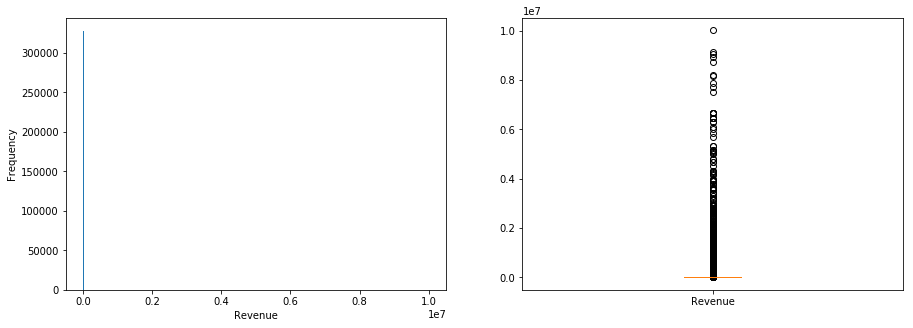

In [5]:
# n_samples stores the number of rows (aka samples) of the dataset
n_samples = len(receitas_br_df)
# Calculating the number of bins based on the square root of the samples since it's a common way
# to set this number for usage on histograms
n_bins = int(np.sqrt(n_samples))

_ = plt.subplots(nrows=1, ncols=2, figsize=(15, 5), facecolor='w', edgecolor='w')

# Plotting the histogram to see the distribution of revenue data values
_ = plt.subplot(1, 2, 1)
# Log has been applied for the data
_ = plt.hist(receitas_br_df['VR_RECEITA'], bins=n_bins)
_ = plt.xlabel('Revenue')
_ = plt.ylabel('Frequency')

_ = plt.subplot(1, 2, 2)
_ = plt.boxplot(receitas_br_df['VR_RECEITA'], labels=['Revenue'])

receitas_br_df.VR_RECEITA.describe()

As we can see on the info shown when calling `describe` function on the dataframe, the revenue value are very sparse, varying from `R$ 0.01` to `R$ 10,015,028.75` (represented above in scientific notation) through our 330,606 data points. Having a standard deviation much bigger than the mean also show us how widely spread our values are about the mean. Looking to the histogram and boxplot it's clear that most of the revenue values are concentrated in vary small values, making it impossible to visualize a distribution on the histogram and the box on the boxplot, emphasizing on the graph just the outliers to the data.

This behaviour may be due to a big variation in the revenue data for different classes. In example, we think that different donation types may have a different range of values and distribution because the magnitude of the values for different types are probably not same. E.g.: values donated by a physical person may be much less than those whose come from the parties fund. Below we will begin to explore these differences.

Before we begin to analyze the data by classes we're going to add two variations of the revenue field to the DataFrame. The first one aims to convert the values to a more "readable" scale to make it easy for us and other people reading the EDA to understand the data values. To do so, we're going to add a columns with revenue value in the millions scale. The other field is going to be the application of a normalization technique that will make the values fall within a smaller and specified range and that can help us when applying data mining functions. To this normalization, we're going to apply the min-max normalization.

In [6]:
# Adding new field with revenue values on the million scale

# Adding a columns to the DataFrame with revenue in the million scale to facilitate the readbility of the values
# the round function is applied to also make it a better number to read and understand
receitas_br_df['VR_RECEITA_MILHOES'] = (receitas_br_df['VR_RECEITA'] / (10 ** 6)).round(decimals=2)

"""
# n_samples stores the number of rows (aka samples) of the dataset
n_samples = len(receitas_br_df)
# Calculating the number of bins based on the square root of the samples since it's a common way
# to set this number for usage on histograms
n_bins = int(np.sqrt(n_samples))

_ = plt.subplots(nrows=1, ncols=2, figsize=(15, 5), facecolor='w', edgecolor='w')

# Plotting the histogram to see the distribution of revenue data values
_ = plt.subplot(1, 2, 1)
# Log has been applied for the data
_ = plt.hist(receitas_br_df['VR_RECEITA_MILHOES'], bins=n_bins)
_ = plt.xlabel('Revenue (millions)')
_ = plt.ylabel('Frequency')

_ = plt.subplot(1, 2, 2)
_ = plt.boxplot(receitas_br_df['VR_RECEITA_MILHOES'], labels=['Revenue (millions)'])
"""

receitas_br_df.VR_RECEITA_MILHOES.describe()

count    328645.000000
mean          0.002268
std           0.090803
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          10.020000
Name: VR_RECEITA_MILHOES, dtype: float64

In [7]:
def get_bin_size(df):
    n_samples = len(df)
    n_bins = int(np.sqrt(n_samples))
    return n_bins

# Adding a column to the DataFrame with the Revenue normalized using the Min-Max technique
# The normalization could be done using sklearn preprocessing library, but I prefered to do directly below

receitas_br_df['VR_RECEITA_NORM'] = (((receitas_br_df['VR_RECEITA'] - min(receitas_br_df['VR_RECEITA'])) /
                                     (max(receitas_br_df['VR_RECEITA']) - min(receitas_br_df['VR_RECEITA']))) *
                                     (1-0) + 0)

# Describe the new column of the dataframe to see if normalization was done right

print(receitas_br_df['VR_RECEITA_NORM'].describe())

"""
# Plotting the histogram and boxplot with normalized values

_ = plt.subplots(nrows=1, ncols=2, figsize=(15, 5), facecolor='w', edgecolor='w')

bin_size = get_bin_size(receitas_br_df['VR_RECEITA_NORM'])
_ = plt.subplot(1, 2, 1)
_ = plt.hist(receitas_br_df['VR_RECEITA_NORM'], bins=bin_size)
_ = plt.xlabel('Revenue (Min-Max Normalization)')
_ = plt.ylabel('Frequency')

_ = plt.subplot(1, 2, 2)
_ = plt.boxplot(receitas_br_df['VR_RECEITA_NORM'], labels=['Revenue (Min-Max Normalization)'])
"""

receitas_br_df.head()

count    328645.000000
mean          0.000235
std           0.009066
min           0.000000
25%           0.000001
50%           0.000003
75%           0.000005
max           1.000000
Name: VR_RECEITA_NORM, dtype: float64


,NR_CNPJ_PRESTADOR_CONTA,SG_PARTIDO,NM_PARTIDO,CD_TP_ORIGEM_DOACAO,DS_TP_ORIGEM_DOACAO,NR_CPF_CNPJ_DOADOR,NM_DOADOR,SQ_CANDIDATO_DOADOR,NR_CANDIDATO_DOADOR,CD_CANDIDATO_CARGO_DOADOR,...,DS_TP_FONTE_RECURSO,CD_TP_NATUREZA_RECURSO,DS_TP_NATUREZA_RECURSO,CD_TP_ESPECIE_RECURSO,DS_TP_ESPECIE_RECURSO,DT_RECEITA,DS_RECEITA,VR_RECEITA,VR_RECEITA_MILHOES,VR_RECEITA_NORM
11,59933952000100,AVANTE,AVANTE,0.0,COTAS DO FUNDO PARTIDÁRIO,5.090180e+11,TRIBUNAL SUPERIOR ELEITORAL,NaN,NaN,NaN,...,FUNDO PARTIDÁRIO,0,Financeiro,5.0,Ordem bancária,01/03/2017,FUNDO PARTIDÁRIO - DIREÇÃO NACIONAL - COTAS RE...,603334.62,0.60,0.060243
12,59933952000100,AVANTE,AVANTE,0.0,COTAS DO FUNDO PARTIDÁRIO,5.090180e+11,TRIBUNAL SUPERIOR ELEITORAL,NaN,NaN,NaN,...,FUNDO PARTIDÁRIO,0,Financeiro,5.0,Ordem bancária,30/05/2017,FUNDO PARTIDÁRIO - DIREÇÃO NACIONAL - COTAS RE...,471231.00,0.47,0.047052
13,59933952000100,AVANTE,AVANTE,0.0,COTAS DO FUNDO PARTIDÁRIO,5.090180e+11,TRIBUNAL SUPERIOR ELEITORAL,NaN,NaN,NaN,...,FUNDO PARTIDÁRIO,0,Financeiro,5.0,Ordem bancária,26/12/2017,FUNDO PARTIDÁRIO - DIREÇÃO NACIONAL - COTAS RE...,834373.70,0.83,0.083312
14,59933952000100,AVANTE,AVANTE,0.0,COTAS DO FUNDO PARTIDÁRIO,5.090180e+11,TRIBUNAL SUPERIOR ELEITORAL,NaN,NaN,NaN,...,FUNDO PARTIDÁRIO,0,Financeiro,5.0,Ordem bancária,28/11/2017,FUNDO PARTIDÁRIO - DIREÇÃO NACIONAL - COTAS RE...,566750.43,0.57,0.056590
15,59933952000100,AVANTE,AVANTE,0.0,COTAS DO FUNDO PARTIDÁRIO,5.090180e+11,TRIBUNAL SUPERIOR ELEITORAL,NaN,NaN,NaN,...,FUNDO PARTIDÁRIO,0,Financeiro,5.0,Ordem bancária,27/03/2017,FUNDO PARTIDÁRIO - DIREÇÃO NACIONAL - COTAS RE...,618056.35,0.62,0.061713


Below we're going to begin the exploration of data shape and distribution within the type of donation classe (represented in the `CD_TP_ORIGEM_DOACAO` (as code) and `DS_TP_ORIGEM_DOACAO` (as description) columns of the DataFrame).

To begin to understand the data in a catagorical way, we're going to plot a strip plot, which is a kind of variation of the scatter plot where one variable is categorical. In this case, our categorical variable is the type of donation and we want to see the revenue for each type. We wanted to display a [beeswarm plot](https://seaborn.pydata.org/generated/seaborn.swarmplot.html) but this type of plot does not performs well when the number of data points is big, so, that is why we choose to use the Strip plot

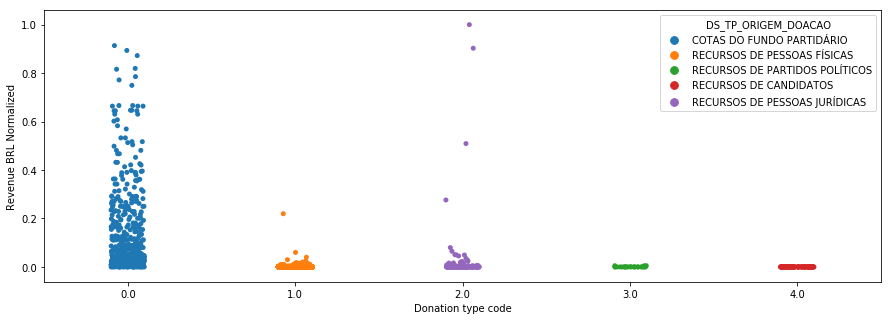

In [8]:
# Setting the figure size for a good visualization
fig, ax = plt.subplots(figsize=(15, 5))

# Plotting the strip plot. The category on the X axis is the code because when plotting with the description
# they we're overlapping each other. We plotted them on the legend for easier understading
sns.stripplot(x='CD_TP_ORIGEM_DOACAO', y='VR_RECEITA_NORM', hue='DS_TP_ORIGEM_DOACAO', data=receitas_br_df, ax=ax)
_ = plt.xlabel('Donation type code')
_ = plt.ylabel('Revenue BRL Normalized')

The plot above confirms our suspects that different types of donation origin have a different distribution. Looking to it, we can clearly see that revenue from Fundo Partidário is the most spread and also that the other type of donations have the vast majority of it's values between 0 and 0.2 (maybe even 0.1). Now it is clear why our histogram has a single bar near the 0 point and also why our boxplot has so many outliers. The scale of each type of donation is so different that it's not clueless to work with all of them in the same analysis.

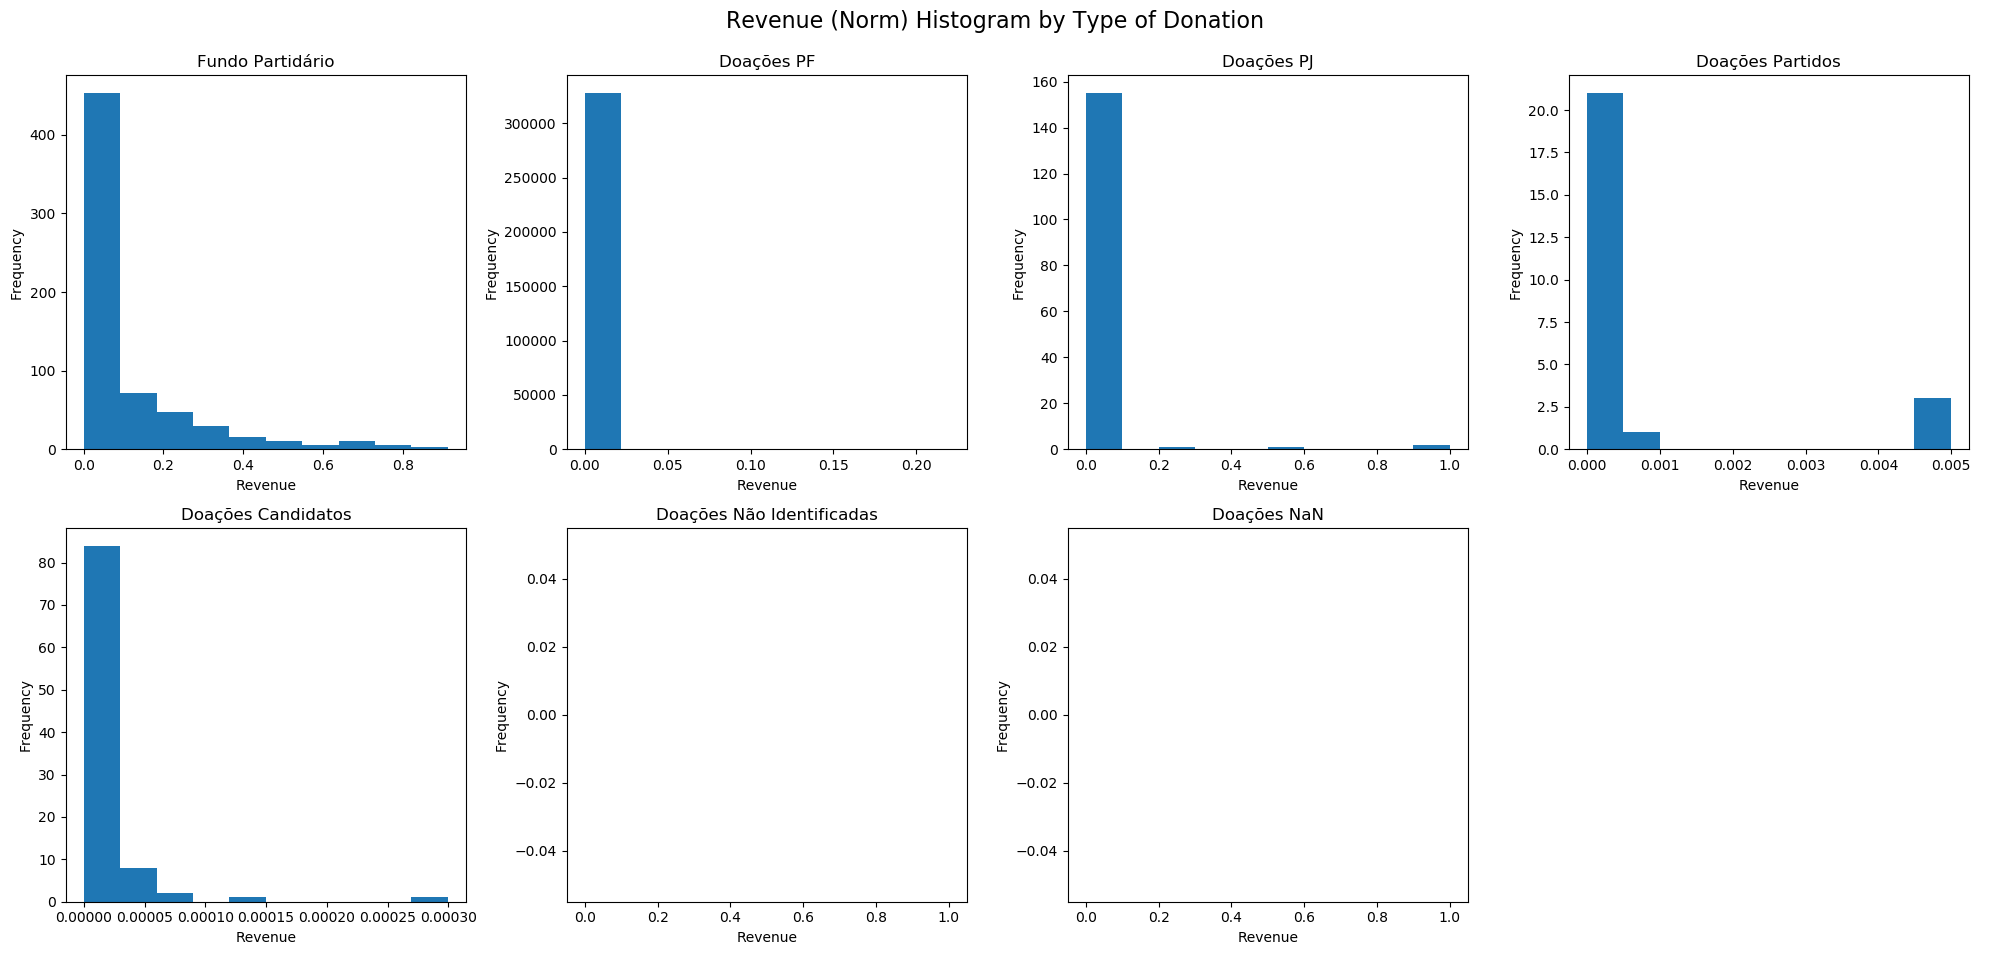

In [9]:
# Separating the different types of donations in distinct DataFrames
"""
0 - COTAS DO FUNDO PARTIDÁRIO
1 - RECURSOS DE PESSOAS FÍSICAS
2 - RECURSOS DE PESSOAS JURÍDICAS
3 - RECURSOS DE PARTIDOS POLÍTICOS
4 - RECURSOS DE CANDIDATOS
7 - ORIGEM NÃO IDENTIFICADA
"""

fundo_partidario = receitas_br_df[receitas_br_df['CD_TP_ORIGEM_DOACAO'] == 0]
doacoes_pf = receitas_br_df[receitas_br_df['CD_TP_ORIGEM_DOACAO'] == 1]
doacoes_pj = receitas_br_df[receitas_br_df['CD_TP_ORIGEM_DOACAO'] == 2]
doacoes_partidos = receitas_br_df[receitas_br_df['CD_TP_ORIGEM_DOACAO'] == 3]
doacoes_candidatos = receitas_br_df[receitas_br_df['CD_TP_ORIGEM_DOACAO'] == 4]
doacoes_undefined = receitas_br_df[receitas_br_df['CD_TP_ORIGEM_DOACAO'] == 7]
doacoes_nan = receitas_br_df[receitas_br_df['CD_TP_ORIGEM_DOACAO'].isnull()]

# Plotting one histogram for each possible type of donation

_ = plt.subplots(nrows=2, ncols=4, figsize=(20, 10), dpi=100, facecolor='w', edgecolor='w')

bin_size = get_bin_size(fundo_partidario)
_ = plt.subplot(2, 4, 1)
_ = plt.title('Fundo Partidário')
_ = plt.xlabel('Revenue')
_ = plt.ylabel('Frequency')
_ = plt.hist(fundo_partidario['VR_RECEITA_NORM'])

bin_size = get_bin_size(doacoes_pf)
_ = plt.subplot(2, 4, 2)
_ = plt.title('Doações PF')
_ = plt.xlabel('Revenue')
_ = plt.ylabel('Frequency')
_ = plt.hist(doacoes_pf['VR_RECEITA_NORM'])

bin_size = get_bin_size(doacoes_pj)
_ = plt.subplot(2, 4, 3)
_ = plt.title('Doações PJ')
_ = plt.xlabel('Revenue')
_ = plt.ylabel('Frequency')
_ = plt.hist(doacoes_pj['VR_RECEITA_NORM'])

bin_size = get_bin_size(doacoes_partidos)
_ = plt.subplot(2, 4, 4)
_ = plt.title('Doações Partidos')
_ = plt.xlabel('Revenue')
_ = plt.ylabel('Frequency')
_ = plt.hist(doacoes_partidos['VR_RECEITA_NORM'])

bin_size = get_bin_size(doacoes_candidatos)
_ = plt.subplot(2, 4, 5)
_ = plt.title('Doações Candidatos')
_ = plt.xlabel('Revenue')
_ = plt.ylabel('Frequency')
_ = plt.hist(doacoes_candidatos['VR_RECEITA_NORM'])

bin_size = get_bin_size(doacoes_undefined)
_ = plt.subplot(2, 4, 6)
_ = plt.title('Doações Não Identificadas')
_ = plt.xlabel('Revenue')
_ = plt.ylabel('Frequency')
_ = plt.hist(doacoes_undefined['VR_RECEITA_NORM'])

bin_size = get_bin_size(doacoes_nan)
_ = plt.subplot(2, 4, 7)
_ = plt.title('Doações NaN')
_ = plt.xlabel('Revenue')
_ = plt.ylabel('Frequency')
_ = plt.hist(doacoes_nan['VR_RECEITA_NORM'])

# Don't show the last (empty) subplot

_ = plt.subplot(2, 4, 8)
_ = plt.axis('off')


_ = plt.suptitle('Revenue (Norm) Histogram by Type of Donation', fontsize=16)
# rect param adjusts the layout so suptitle does not overlap the other plots
_ = plt.tight_layout(rect=[0, 0.03, 1, 0.95])

c:\users\aiqui\appdata\local\programs\python\python36\lib\site-packages\numpy\core\fromnumeric.py:52: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


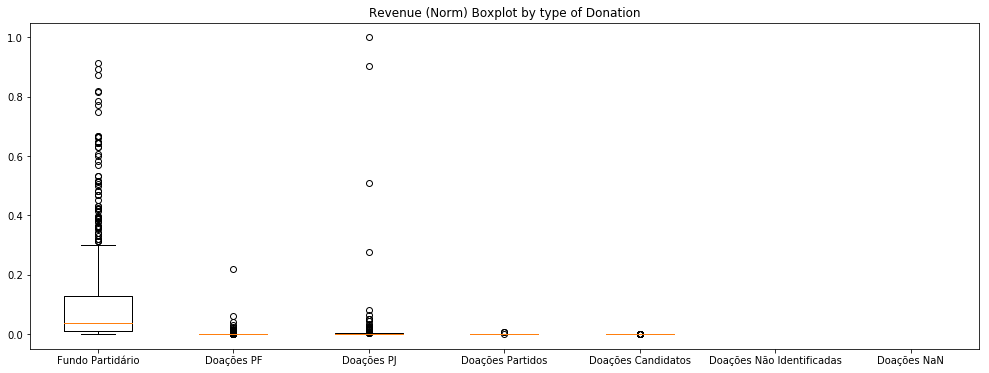

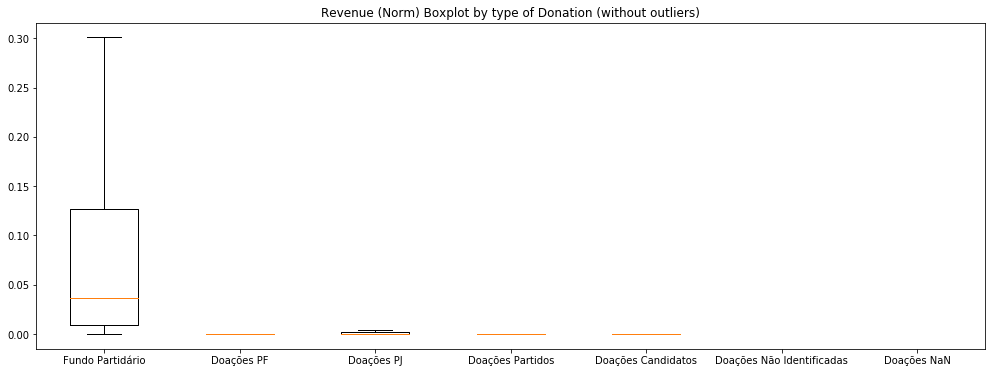

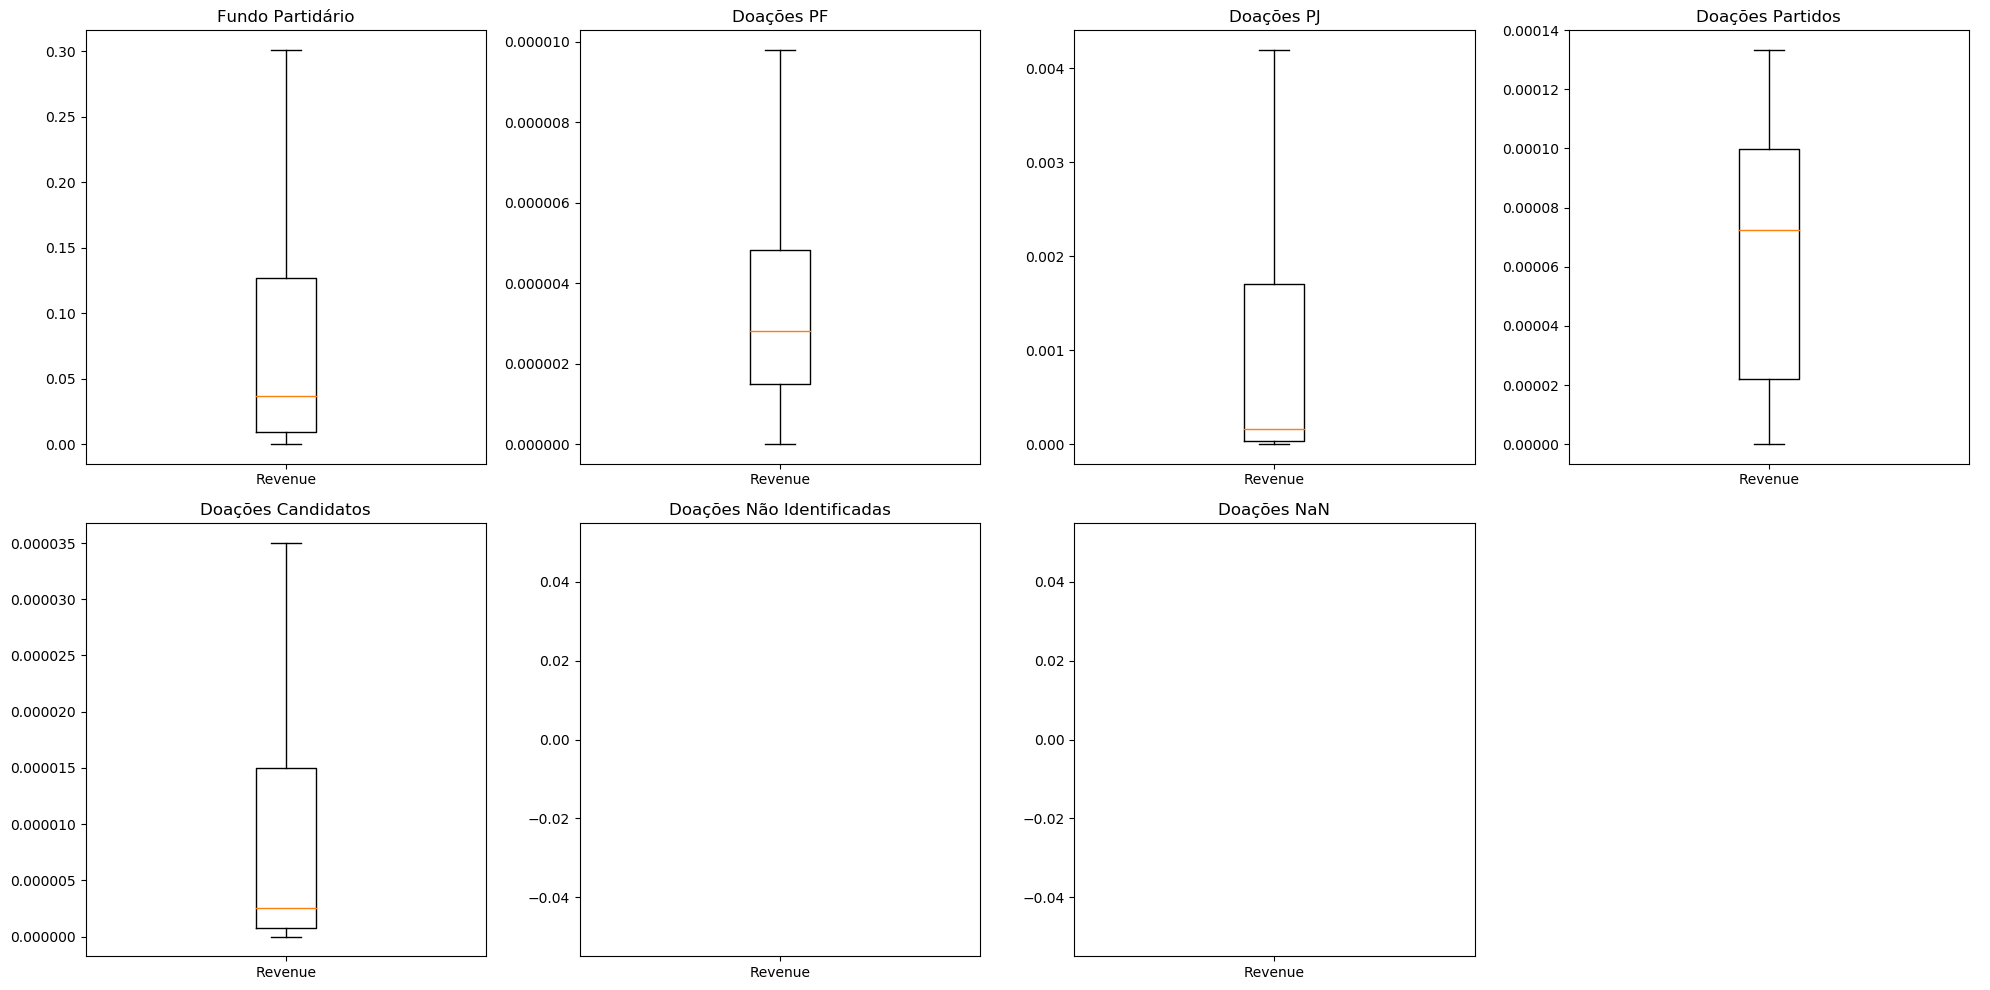

In [10]:
# Plotting all the boxes on the same graph/scale with their outliers

_ = plt.subplots(figsize=(17, 6))

_ = plt.title('Revenue (Norm) Boxplot by type of Donation')
_ = plt.boxplot((fundo_partidario['VR_RECEITA_NORM'],
                 doacoes_pf['VR_RECEITA_NORM'],
                 doacoes_pj['VR_RECEITA_NORM'],
                 doacoes_partidos['VR_RECEITA_NORM'],
                 doacoes_candidatos['VR_RECEITA_NORM'],
                 doacoes_undefined['VR_RECEITA_NORM'],
                 doacoes_nan['VR_RECEITA_NORM']),
                 labels=['Fundo Partidário', 'Doações PF', 'Doações PJ',
                         'Doações Partidos', 'Doações Candidatos', 
                         'Doações Não Identificadas', 'Doações NaN'])


# Plotting all the boxes on the same graph/scale without their outliers

_ = plt.subplots(figsize=(17, 6))

_ = plt.title('Revenue (Norm) Boxplot by type of Donation (without outliers)')
_ = plt.boxplot((fundo_partidario['VR_RECEITA_NORM'],
                 doacoes_pf['VR_RECEITA_NORM'],
                 doacoes_pj['VR_RECEITA_NORM'],
                 doacoes_partidos['VR_RECEITA_NORM'],
                 doacoes_candidatos['VR_RECEITA_NORM'],
                 doacoes_undefined['VR_RECEITA_NORM'],
                 doacoes_nan['VR_RECEITA_NORM']),
                 labels=['Fundo Partidário', 'Doações PF', 'Doações PJ',
                         'Doações Partidos', 'Doações Candidatos', 
                         'Doações Não Identificadas', 'Doações NaN'],
                 sym='')

# Plotting one boxplot for each possible type of donation

_ = plt.subplots(nrows=2, ncols=4, figsize=(20, 10), dpi=100, facecolor='w', edgecolor='w')

_ = plt.subplot(2, 4, 1)
_ = plt.title('Fundo Partidário')
_ = plt.boxplot(fundo_partidario['VR_RECEITA_NORM'], labels=['Revenue'], sym='')

_ = plt.subplot(2, 4, 2)
_ = plt.title('Doações PF')
_ = plt.boxplot(doacoes_pf['VR_RECEITA_NORM'], labels=['Revenue'], sym='')

_ = plt.subplot(2, 4, 3)
_ = plt.title('Doações PJ')
_ = plt.boxplot(doacoes_pj['VR_RECEITA_NORM'], labels=['Revenue'], sym='')

_ = plt.subplot(2, 4, 4)
_ = plt.title('Doações Partidos')
_ = plt.boxplot(doacoes_partidos['VR_RECEITA_NORM'], labels=['Revenue'], sym='')

_ = plt.subplot(2, 4, 5)
_ = plt.title('Doações Candidatos')
_ = plt.boxplot(doacoes_candidatos['VR_RECEITA_NORM'], labels=['Revenue'], sym='')

_ = plt.subplot(2, 4, 6)
_ = plt.title('Doações Não Identificadas')
_ = plt.boxplot(doacoes_undefined['VR_RECEITA_NORM'], labels=['Revenue'], sym='')

_ = plt.subplot(2, 4, 7)
_ = plt.title('Doações NaN')
_ = plt.boxplot(doacoes_nan['VR_RECEITA_NORM'], labels=['Revenue'], sym='')

# Don't show the last (empty) subplot

_ = plt.subplot(2, 4, 8)
_ = plt.axis('off')

_ = plt.tight_layout()

By looking to the histogram and the boxplots, it's clear that different types of donation have different scales, what makes it difficult even to see the boxes when plotting them on the same scale. Visualizing them separately is a better way to understand the shape of data for each donation type. 

Below we're going to plot the share of each donation type for the whole.

Sum of Fundo Partidário: 702569763.3900008. Share of revenue: 0.9089519016559672
Sum of Doações PF: 36555499.68000959. Share of revenue: 0.04729379583573709
Sum of Doações PJ: 33635792.90000001. Share of revenue: 0.043516415754416476
Sum of Doações Partidos: 169989.90000000002. Share of revenue: 0.00021992498242702878
Sum of Doações Candidatos: 13883.46. Share of revenue: 1.796177123774034e-05
Sum of Doações Não Identificadas: 0. Share of revenue: 0.0


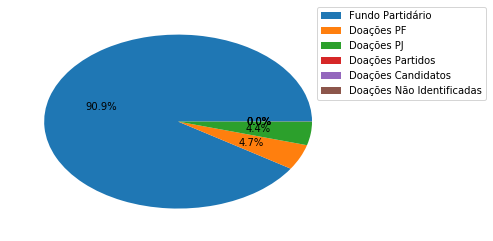

In [11]:
print('Sum of {}: {}. Share of revenue: {}'.format('Fundo Partidário',
                                                   sum(fundo_partidario['VR_RECEITA']),
                                                   sum(fundo_partidario['VR_RECEITA']) / sum(receitas_br_df['VR_RECEITA'])))
print('Sum of {}: {}. Share of revenue: {}'.format('Doações PF',
                                                   sum(doacoes_pf['VR_RECEITA']),
                                                   sum(doacoes_pf['VR_RECEITA']) / sum(receitas_br_df['VR_RECEITA'])))
print('Sum of {}: {}. Share of revenue: {}'.format('Doações PJ',
                                                   sum(doacoes_pj['VR_RECEITA']),
                                                   sum(doacoes_pj['VR_RECEITA']) / sum(receitas_br_df['VR_RECEITA'])))
print('Sum of {}: {}. Share of revenue: {}'.format('Doações Partidos',
                                                   sum(doacoes_partidos['VR_RECEITA']),
                                                   sum(doacoes_partidos['VR_RECEITA']) / sum(receitas_br_df['VR_RECEITA'])))
print('Sum of {}: {}. Share of revenue: {}'.format('Doações Candidatos',
                                                   sum(doacoes_candidatos['VR_RECEITA']),
                                                   sum(doacoes_candidatos['VR_RECEITA']) / sum(receitas_br_df['VR_RECEITA'])))                                                  
print('Sum of {}: {}. Share of revenue: {}'.format('Doações Não Identificadas',
                                                   sum(doacoes_undefined['VR_RECEITA']),
                                                   sum(doacoes_undefined['VR_RECEITA']) / sum(receitas_br_df['VR_RECEITA'])))                                                  

sum_revenue_types = [sum(fundo_partidario['VR_RECEITA']),
                     sum(doacoes_pf['VR_RECEITA']),
                     sum(doacoes_pj['VR_RECEITA']),
                     sum(doacoes_partidos['VR_RECEITA']),
                     sum(doacoes_candidatos['VR_RECEITA']),
                     sum(doacoes_undefined['VR_RECEITA'])]
labels = ['Fundo Partidário', 'Doações PF', 'Doações PJ',
          'Doações Partidos', 'Doações Candidatos', 
          'Doações Não Identificadas']
_ = plt.pie(sum_revenue_types,
            autopct='%1.1f%%')
_ = plt.legend(labels, bbox_to_anchor=(0.9, 1.05))

As we can see on the pie chart above, most of the political parties revenue in 2017 came from Fundo Partidário (*parties fund*), that is a public tool to fund Brazilian's political parties. According to Tribunal Superior Eleitoral (TSE), this fund consists of "Union budget appropriations, fines, penalties, donations and other financial resources assigned to them by law".

The sum of Fundo Partidário is equal to `R$ 702,569,763` but on TSE's site, the value they say that was distributed from the fund to the parties in 2017 is `R$ 741,724,022`, summing the twelfth distribution and the fines. We're going to ask TSE about this difference on the data provided and the data published on their reports.

Since we have this difference on Fundo Partidário, we're going to focus our analysis on the other donation types, specially donations from physical and juridic people. We think that this approach is the most interest since these are the types that show people and companies support to parties. Even though the parties fund is the biggest revenue, the way it's distributed is agreed by law. If we have time, we're going to get back to it to check if the distribution is the same as is reported on TSE's site.

As a last analysis of Fundo Partidário, let's just see a distribution of it for each Political Party.

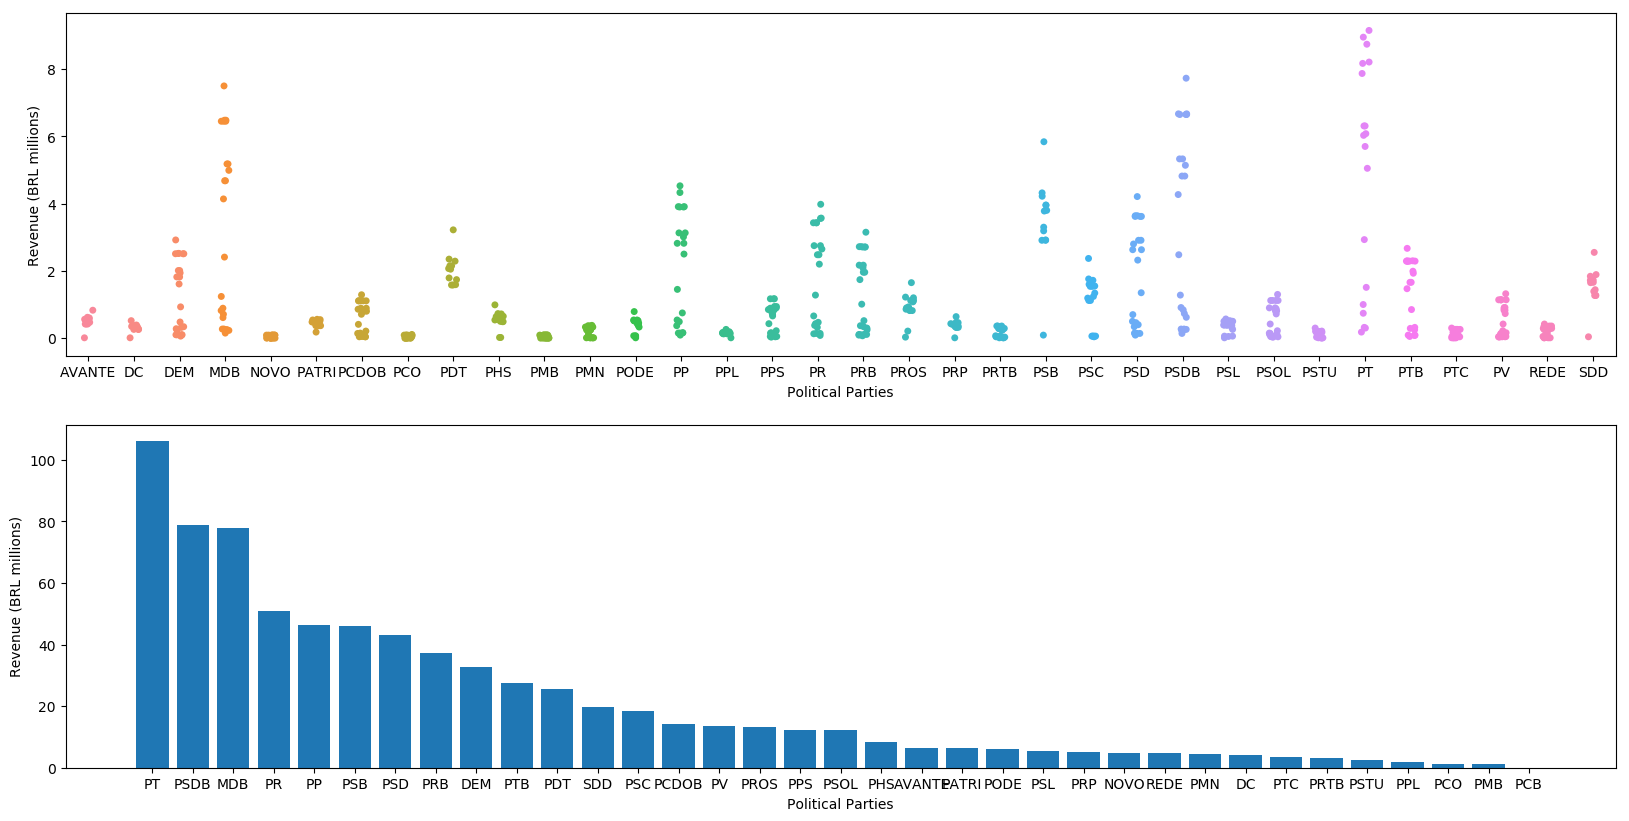

In [12]:
# Setting the subplots configuration
_ = plt.subplots(nrows=2, ncols=1, figsize=(20, 10), dpi=100, facecolor='w', edgecolor='w')

# Plotting the strip plot to see the distribution of revenues for each party
# The data points correspond to a donation record, with some overlapping, which is a charactheristic of the strip plot
_ = plt.subplot(2, 1, 1)
sns.stripplot(x='SG_PARTIDO', y='VR_RECEITA_MILHOES', data=fundo_partidario)
_ = plt.xlabel('Political Parties')
_ = plt.ylabel('Revenue (BRL millions)')

# Creating a DataFrame with sum of revenue (millions) grouped by Party for making the plot easy
fundo_partidario_partido = receitas_br_df[['SG_PARTIDO', 'VR_RECEITA_MILHOES']]
fundo_partidario_partido = fundo_partidario_partido.groupby(['SG_PARTIDO']).sum().reset_index()
fundo_partidario_partido.sort_values(by='VR_RECEITA_MILHOES', ascending=False, inplace=True)

# Plotting a bar chart of total revenue received from Fundo Partidário by Political Party
_ = plt.subplot(2, 1, 2)
_ = plt.bar(fundo_partidario_partido['SG_PARTIDO'],
            fundo_partidario_partido['VR_RECEITA_MILHOES'])
_ = plt.xlabel('Political Parties')
_ = plt.ylabel('Revenue (BRL millions)')

## Physical and Juridic person donation analysis

As discussed in this analysis so far, we saw that most of the revenue of Brazilian Political Parties in 2017 came from *fundo partidário*(~91%). Most of the rest of the revenue (~9%) came mainly from two other sources: donations from physical (citizen) and juridic person (companies). From now on we're going to apply data mining techniques to explore and generate knowledge from these data.

**Ideas:**

- Find some pattern on the donations
    - Person/company who donates for party X also donates do party Y
- Predict for which party a donation is for